# Project: LSTM_module

LSTM을 활용한 보이스피싱 탐지 모듈 개발

## 순서
1. import: 필요한 모듈 import
2. 데이터 셋 불러오기(load)
2. 전처리: 학습에 필요한 데이터 전처리 수행
3. 모델링(model): 모델 정의
4. 컴파일(compile): 모델 생성
5. 학습(fit): 모델 학습

## 모듈 import

In [449]:
import os

import json
import pickle
import re

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from collections import Counter

from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## 파일 이름 선언

필요 변수, 모델, 토큰 객체 등 파일 이름 선언

In [450]:
file_name = "LSTM_module_ver4.0"

## 데이터 셋 불러오기

빈 list 생성

In [451]:
spam_X = []
spam_temp = []
ham_X = []
ham_temp = []

* `ham_count`: 일반 데이터 개수 제한
* `min_data`: 텍스트 데이터 최소 길이
* `data_length`: 텍스트 데이터 일반 길이

In [452]:
ham_count = 10000
min_data = 150
data_length = 200

보이스피싱 통화 데이터 가져오기

In [453]:
path = '../../fraudDataset/spamData/'
path1 = os.listdir(path)
for a in path1:
    path2 = path+a
    with open(path2, 'r', encoding='utf-8') as f:
        contents = f.read()
        contents = re.sub("#@(.+?)#|네|[^가-힣 ]", "", contents) # 특수문자 제거
        spam_temp.append(contents)

일반 통화 데이터 가져오기

In [454]:
contents = ""
path = '../../fraudDataset/hamData/'
path1 = os.listdir(path)
for a in path1:
    
    if len(ham_temp) > ham_count:
        break
    
    path2 = os.listdir(path+a)
    for b in path2:
        
        if len(ham_temp) > ham_count:
            break
        
        path3 = os.listdir(path+a+'/'+b)
        for c in path3:
            
            if len(ham_temp) > ham_count:
                break
                    
            path4 = os.listdir(path+a+'/'+b+'/'+c)
            for d in path4:
                
                if len(ham_temp) > ham_count:
                    break
                
                path5 = os.listdir(path+a+'/'+b+'/'+c+'/'+d)
                for e in path5:
                    
                    if len(ham_temp) > ham_count:
                        break
                    
                    path6 = os.listdir(path+a+'/'+b+'/'+c+'/'+d+'/'+e)

                    if len(contents) > min_data:
                        ham_temp.append(contents)

                    contents = ""
                    for f in path6:
                        
                        if len(ham_temp) > ham_count:
                            break
                        
                        if f.split(".")[1] == "txt":
                            path7 = path+a+'/'+b+'/'+c+'/'+d+'/'+e+'/'+f
                        else:
                            continue
                        with open(path7, "r", encoding="UTF-8") as f:
                            text = f.read()
                            text = re.sub("#@(.+?)#|네|[^가-힣 ]", "", text) # 특수문자 제거

                        contents += text+" "
                        if len(contents) > max_data:
                            ham_temp.append(contents)
                            contents = ""
                            
ham_X = ham_temp

노인남녀/일반남녀 대화 데이터 가져오기

In [455]:
# path = '../../jsonDataset/dataset/'
# path1 = os.listdir(path)
# for a in path1:
#     path2 = os.listdir(path+a)
#     for b in path2:
#         path3 = os.listdir(path+a+'/'+b)
#         for c in path3:
#             path4 = os.listdir(path+a+'/'+b+'/'+c)
#             for d in path4:
#                 path5 = os.listdir(path+a+'/'+b+'/'+c+'/'+d)                    
#                 for e in path5:
#                     path6 = path+a+'/'+b+'/'+c+'/'+d+'/'+e
#                     with open(path6, "r", encoding="UTF-8") as f:
#                         contents = f.read()
#                         json_data = json.loads(contents)
#                         data = ''
#                         data = json_data['발화정보']['stt']
                        
#                         if a == '자유대화 음성(노인남녀)':
#                             spam_temp.append(data) # 노인남녀
#                         else:
#                             ham_temp.append(data) # 일반남녀

피싱 데이터 5개 출력

In [456]:
spam_temp[:5]

['여보세요  안녕하세요 검찰청이에요 검찰청이요  통화 괜찮으십니까  가능합니다 전화 받으신 분이 김윤환 씨 맞으시죠  맞습니다예 다름이 아니라 본인과 연루된 명의도용 사건이 접수가 돼서 지금까지 확인 좀 해서 연락을 드렸고요 명의도용이요 예 통화 괜찮으시면은 외모 할 만한 거 한번 준비하셔가지고이렇게 말씀 한번 해 주세요예 준비됐습니다예 일단 지금 김유나 씨께서 혹시 김용식이라고 아시는 분이신가요 김용식김용식이요처음 들어보세요 그러면은 년도 월 경에 경기도 광명에 방문하신 적이 있으세요광명이요 기억이 잘 안 나요오시고 제가 이 두 가지 질문드린 게요  얼마 전에 이제 김용식 필두로 한 금융범죄 사기단을 검거를 했어요 이 구조 과정 중에 만약에 신용카드가 대포통장을 압수 했는데  거기에 서서 본인 명의로 돼 우리은행 계좌건을 확인이 됐습니다 근데 이 계좌건을 제가 추적을 해 보니까 문의 같은 경우에는 주소지가 서울시 관악구로 나와 있는데 통장 계설은 방금 제가 여쭤봤던 경기도 광명시에서 년도 월 경이 됐거든요 그래서 이거를 김유나 씨께서 광명까지 직접 가셔가지고 이 팀장까지 개선해서 문자분에게 건넨 건지 아니면 개인정보 유출로 인해서 명의도용을 당한 피해자분이신지 진의 여부를 확인하고 연락을 드린 겁니다아마 저는 피해자일 거예요  제가 가담을 안 했으니까요 본인이 직접 만들 계산하시는 게 없다 이 말씀이시잖아요  그렇죠 그러면은 개인정보 유출 관련해가지고  주식은 년에서 년 사이에 신분증이나 통장을 분실했다거나 본인이 올리자는 글이 올라왔다거나 로그인을 하지 않았는데 로그인되서 않으면 받을 수제가 회사 홍보는 하는데 이게 그 이외에는 제가 딱히 이렇게 개인 정보를 올리진 않거든요 누가 악질적으로 이렇게 개인 정보를 캐가지 않는 이상 저는 노출 시키지는 않습니다그거를 그 본인이 올린 게 아니라 다른 분들이 올린 거를 본인께서 확인된 적이 있으시냐 그 말입니다아니요 못 본 것 같아요 맞아요 이거 그리고 제가 사건번건호 이거 조회를 한 번 하셔야 되는데 사건 번호 

일반 데이터 5개 출력

In [457]:
ham_temp[:5]

['안녕하세요 쉐어링 스터디 상담원 이주빈입니다 예 안녕하세요 제가 다른 게 아니라 나이가 좀 있는 지라 강좌를 결재 방법이 조금 어려워서 여쭤보려고 합니다 그거 쉐어링 캐시충전이었나 그게 처음에  마이 페이지를 들어가서 캐시를 버튼을 누르고 캐시 할인권 메뉴에서  쉐어링 캐시 그리고 충전하기 버튼을 누르면 되는게 맞나요  맞습니다 그런 다음 제가 뭐냐 어 충전하려고 하는 금액을 쓴다음에 ',
 '결제를 누르면 되는거구요 그리고 나서 제가 결제수단을 누르는데 문화상품권 받는 거로 하는데 무슨 컬쳐 캐쉬 컬쳐 랜드 거기에 가입을 하라고 나오는데 전  쉐어링 스터디 가입을 하는 데 이게 뭐죠 막 이상한 사이트로 연결되던데 그리고 무슨 코드 같은 거 다섯칸 입력하는게 나오던데 이건 또 어떻게 하는거죠 문화상품권 은색부분을 긁으셔서 컬쳐 랜드 충전을 하셔야 합니다 ',
 '거기가 충전 사이트예요 그럼 이거 가입 안 하면은 안돼요 가입하는 것도 저한테는 너무 어려워서 이거 가입하는것도 손주한테 부탁을 해서 한 거라서 뭐 여기서 바로 하는 거 없어요 그냥 제가 그쪽에서 그쪽한테 사진 찍어서 문자로 보내주면 안되나 죄송합니다 고객님 그럼 어떻게 해요 간편한 방법을 원하시면 무통장 입금을 이용하셔도 됩니다 휴대폰 결제로 하면 쉬워 그러면 이거 결제를 누르고 무통장 입금인가 뭔가를 선택하고 나서 ',
 '내가 은행 가서 그 계좌번호로 돈을 넣어주면 되는 건가 아 알겠어요  그러면 또 하나 물어봅시다 이게 무통장 입금할 때 제가 아내 명의로 된 통장을 쓰고 있는데 그 입금 이름이 달라도 상관이 없는 거예요 어 다른 곳은 안된다는 곳도 있고 해서 일치하지 않아도 괜찮습니다 그럼 이거 확인은 언제 되는 거예요 삼십분 내로 확인됩니다 그럼 어차피 지금 은행 근처니까 바로 입금할테니 확인해주고 빨리 충전해주세요 ',
 '혹시 그러다가 내가 잘못 눌러서 금액을 더 많이 보내 버리면 어떡해 그러면 환불해주나 다시 환불됩니다 그럼 내가 충분한 금액은 결제가 안되고 아닙니다 충전됩니다 어 예

## 텍스트 데이터 분리

**findIndex**: 문장이 끝나는 부분의 index값을 찾기위한 함수

In [458]:
def findIndex(data_list, split_list, start_index):
    index_list = []
    for i in split_list:
        index = data_list.find(i, start_index)
        index_list.append(index)
        
    index_list = [i for i in index_list if i not in [-1]]
    if index_list == []:
        return -1
    
    index = min(index_list)
    
    return index     

* `split_list`: 문장 단위로 분리하기 위한 글자 리스트

In [459]:
split_list = ['다 ','요 ','죠 ', '까 ']

`data_length` 값 이후에 `split_list` 에 있는 문자가 나오면 자르기 (스팸 데이터)

In [460]:
for t in spam_temp:
    t = re.sub("#@(.+?)#|네|[^가-힣 ]", "", t) # 특수문자 제거
    index = findIndex(t, split_list, max_data)
        
    i = 0
    while index != -1:
        x = t[i:index+2]
        spam_X.append(x)
        
        i = index+2
        index = findIndex(t, split_list, i+max_data)
    else:
        x = t[i:]
        if len(x) > min_data:
            spam_X.append(x) # 텍스트 마지막 부분 추가

## 전처리: 데이터 길이 제한

길이가 min 미만 데이터 삭제 후 중복 제거

In [461]:
spam_df = pd.DataFrame(spam_X, columns=['text'])
spam_df.drop(spam_df[spam_df['text'].str.len() < min_data].index, inplace=True) # 길이가 min_data 미만인 데이터 삭제
spam_df.shape[0] - spam_df['text'].nunique() # 중복 개수

8

In [462]:
ham_df = pd.DataFrame(ham_X, columns=['text'])
ham_df.drop(ham_df[ham_df['text'].str.len() < min_data].index, inplace=True) # 길이가 min_data 미만인 데이터 삭제
ham_df.shape[0] - ham_df['text'].nunique() # 중복 개수

11

In [463]:
spam_df.drop_duplicates(subset=['text'], inplace=True) # 중복 제거
spam_df['label'] = 1

spam_df

,text,label
0,여보세요 안녕하세요 검찰청이에요 검찰청이요 통화 괜찮으십니까 가능합니다 전화 ...,1
1,김용식김용식이요처음 들어보세요 그러면은 년도 월 경에 경기도 광명에 방문하신 적이 ...,1
2,문의 같은 경우에는 주소지가 서울시 관악구로 나와 있는데 통장 계설은 방금 제가 여...,1
3,본인이 직접 만들 계산하시는 게 없다 이 말씀이시잖아요 그렇죠 그러면은 개인정보 ...,1
4,못 본 것 같아요 맞아요 이거 그리고 제가 사건번건호 이거 조회를 한 번 하셔야 되...,1
...,...,...
704,예예열여덟 살저는 삼십구세 남성을 말씀드리는 겁니다 그래요거기 아닌가 본데요 그럼이...,1
705,농협은행 신한은행입니다신한은행 거래 안 한 지 오래됐는데저는 뭐 김 본인께서 거래하...,1
706,어떤 거요큰 통장이라고 말씀하는 게 아니라 이 범죄자들이 다른 사람 명의를 도용을 ...,1
707,이창가라는 사람이 진술했을 때는 어떤 사람들은 총장 돈을 통장을 판매를 하신 분...,1


In [509]:
spam_df['text'][8]

'중앙지검 형사부 신영호 수사관입니다 아  다름이 아니라 본인과 연루된 사건이 저희 직원에 접수된 뒤에서 몇 가지 확인서 연락드렸습니다 잠시 통화 가능하시죠  일단 사건 내용 말씀드리기 전에 혹시 충남 천안 태정의 세 남성  이동현이라고 하시는 사람인가요 이동현씨요모르는데요 모르는 사람이요 예예  뭐 평소에 질문을 통해서 들어본 적도 없어요돈 빌려준 적 있냐고요 '

In [464]:
ham_df.drop_duplicates(subset=['text'], inplace=True) # 중복 제거
ham_df['label'] = 0

ham_df

,text,label
0,안녕하세요 쉐어링 스터디 상담원 이주빈입니다 예 안녕하세요 제가 다른 게 아니라 나...,0
1,결제를 누르면 되는거구요 그리고 나서 제가 결제수단을 누르는데 문화상품권 받는 거로...,0
2,거기가 충전 사이트예요 그럼 이거 가입 안 하면은 안돼요 가입하는 것도 저한테는 너...,0
3,내가 은행 가서 그 계좌번호로 돈을 넣어주면 되는 건가 아 알겠어요 그러면 또 하...,0
4,혹시 그러다가 내가 잘못 눌러서 금액을 더 많이 보내 버리면 어떡해 그러면 환불해주...,0
...,...,...
9996,땡 땡강의 들으시고 일 이강의 같이 들어주시면 될 거 같습니다 아아 그게 좋겠요...,0
9997,카드로 가능하시고요 카드번호랑 비밀번호 앞 자리두 자리 말씀해 주시겠어요 그러면...,0
9998,그럼 교재는 어떻게 결제해요 이게 강의비용에 포함되어 있는 거예요거에요 아니면 따로...,0
9999,안녕하세요 아이 학습지 신청하려고 상담전화드렸어요 아이가 초등학교 일 학년인데 수...,0


데이터 정보 출력

In [465]:
print("스팸 데이터 개수 : {}(read) -> {}(drop)".format(len(spam_X),len(spam_df)))
print('스팸 데이터 최소 길이',len(min(spam_df['text'], key=len)))
print('스팸 데이터 최대 길이',len(max(spam_df['text'], key=len)))
print('----------------------------------------------------')
print("일반 데이터 개수 : {}(read) -> {}(drop)".format(len(ham_X),len(ham_df)))
print('일반 데이터 최소 길이',len(min(ham_df['text'], key=len)))
print('일반 데이터 최대 길이',len(max(ham_df['text'], key=len)))

스팸 데이터 개수 : 709(read) -> 701(drop)
스팸 데이터 최소 길이 152
스팸 데이터 최대 길이 499
----------------------------------------------------
일반 데이터 개수 : 10001(read) -> 9990(drop)
일반 데이터 최소 길이 151
일반 데이터 최대 길이 373


스팸 / 일반 데이터 합치기

In [466]:
total_df = pd.concat([spam_df, ham_df], ignore_index=True)

In [467]:
total_df['text'][0]

'여보세요  안녕하세요 검찰청이에요 검찰청이요  통화 괜찮으십니까  가능합니다 전화 받으신 분이 김윤환 씨 맞으시죠  맞습니다예 다름이 아니라 본인과 연루된 명의도용 사건이 접수가 돼서 지금까지 확인 좀 해서 연락을 드렸고요 명의도용이요 예 통화 괜찮으시면은 외모 할 만한 거 한번 준비하셔가지고이렇게 말씀 한번 해 주세요예 준비됐습니다예 일단 지금 김유나 씨께서 혹시 김용식이라고 아시는 분이신가요 '

## Train / Validation Set 분리

0.75 : 0.25 비율로 나누기

In [468]:
train_data, test_data = train_test_split(total_df, test_size = 0.25, random_state = 42) # 훈련용 테스트 데이터 나누기

훈련 / 테스트 데이터 개수 출력

In [469]:
print('데이터 총 개수 :',len(total_df))
print('훈련용 데이터 개수 :', len(train_data))
print('테스트용 데이터 개수 :', len(test_data))

데이터 총 개수 : 10691
훈련용 데이터 개수 : 8018
테스트용 데이터 개수 : 2673


스팸 / 일반 데이터 개수 그래프 비교

   label  count
0      0   7492
1      1    526


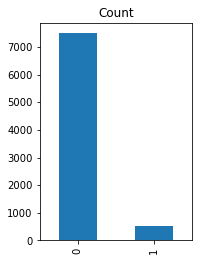

In [470]:
plt.subplot(121)
train_data['label'].value_counts().plot(kind = 'bar', title='Count')
print(train_data.groupby('label').size().reset_index(name = 'count'))

## 전처리: 빈 데이터 처리

빈 데이터 NA 처리

In [471]:
pd.set_option('mode.chained_assignment', None) # 경고 메시지 끄기

train_data.replace('', np.nan, inplace=True)

In [472]:
test_data.replace('', np.nan, inplace=True)

전처리 후 생긴 null 데이터 확인

In [473]:
print(train_data.isnull().sum()) # null 데이터 확인
print()
print(test_data.isnull().sum())

text     0
label    0
dtype: int64

text     0
label    0
dtype: int64


null 값이 있는 행 제거 후 확인

In [474]:
train_data = train_data.dropna(how='any', axis=0)
test_data = test_data.dropna(how='any', axis=0)

print(train_data.isnull().sum()) # null 데이터 확인
print()
print(test_data.isnull().sum())

text     0
label    0
dtype: int64

text     0
label    0
dtype: int64


## 전처리: 토큰화

Okt 객체 선언

In [475]:
okt = Okt() # 한글은 형태소 분석기 사용해야됨 KoNPLY

불용어 단어

In [476]:
stopwords = [] # spam, ham 빈도 수 높은 중복단어 제거

어간 단위로 토큰화 및 불용어 처리

In [477]:
X_train = []
for sentence in train_data['text']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 처리
    X_train.append(temp_X)

In [478]:
X_test = []
for sentence in test_data['text']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 처리
    X_test.append(temp_X)

Dataframe 새 Column에 추가

In [479]:
train_data['tokenized'] = X_train
test_data['tokenized'] = X_test

## 단어별 빈도 수 확인

스팸 단어 빈도 확인

In [480]:
spam_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)
spam_word_count = Counter(spam_words)
print(spam_word_count.most_common(20))

[('하다', 1876), ('이', 1854), ('가', 1180), ('에', 1095), ('을', 1000), ('본인', 874), ('있다', 815), ('되다', 808), ('를', 620), ('지금', 553), ('거', 531), ('저희', 446), ('없다', 432), ('으로', 428), ('는', 426), ('제', 423), ('아니다', 393), ('예', 384), ('은', 361), ('요', 347)]


일상 단어 빈도 확인

In [481]:
ham_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
ham_word_count = Counter(ham_words)
print(ham_word_count.most_common(20))

[('하다', 31533), ('이', 17260), ('가', 11939), ('있다', 11522), ('되다', 10785), ('에', 10524), ('을', 8344), ('그렇다', 7638), ('거', 6569), ('요', 6335), ('는', 6071), ('학습', 5836), ('도', 5821), ('은', 5736), ('를', 5653), ('제', 5602), ('로', 5430), ('아', 5101), ('같다', 4820), ('가능하다', 4567)]


Dataframe 값 추출

In [482]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test = test_data['tokenized'].values
y_test = test_data['label'].values

## 정수 인코딩

`vocab_size`의 값을 정하기 위한 토큰화 객체 생성

In [483]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

최소 단어 빈도 수 제한

In [484]:
threshold = 2 # 등장 횟수가 threshold미만인 단어는 제거

최적의 `vocab_size` 선정

In [485]:
word_to_index = tokenizer.word_index
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
        
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

vocab_size = total_cnt - rare_cnt + 2
print('vocab_size :',vocab_size)

단어 집합(vocabulary)의 크기 : 7717
등장 빈도가 1번 이하인 희귀 단어의 수: 2653
단어 집합에서 희귀 단어의 비율: 34.37864455099132
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.3898197249074674
vocab_size : 5066


단어 토큰화
* `num_words`: 단어 max 사이즈 지정. 빈도수가 높은 순으로 저장.
* `oov_token`: 단어 토큰에 없는 단어 표기법 지정

In [486]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = 'OOV')

`fit_on_texts`로 학습할 문장에 대한 토큰화 진행

In [487]:
tokenizer.fit_on_texts(X_train)

In [488]:
for key, value in tokenizer.word_index.items():
    if len(key) < 4:
        print('{}\t======>\t {}'.format(key, value))
    else:
        print('{}======>\t {}'.format(key, value))
    if value == 25:
        break

OOV	======>	 1
하다	======>	 2
이	======>	 3
가	======>	 4
있다	======>	 5
에	======>	 6
되다	======>	 7
을	======>	 8
그렇다	======>	 9
거	======>	 10
요	======>	 11
는	======>	 12
를	======>	 13
은	======>	 14
도	======>	 15
제	======>	 16
학습	======>	 17
로	======>	 18
아	======>	 19
같다	======>	 20
가능하다======>	 21
것	======>	 22
으로	======>	 23
수	======>	 24
일	======>	 25


토큰화된 단어 사전의 개수

In [489]:
len(tokenizer.word_index)

7718

문장을 토큰으로 치환

In [490]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

변환된 Sequences 확인

In [491]:
X_train[:5]

[[199,
  34,
  1889,
  201,
  188,
  3529,
  98,
  34,
  8,
  1889,
  82,
  152,
  57,
  123,
  2,
  59,
  31,
  447,
  109,
  133,
  26,
  59,
  470,
  7,
  62,
  11,
  62,
  244,
  111,
  102,
  34,
  15,
  188,
  687,
  18,
  210,
  22,
  15,
  470,
  2,
  175,
  90,
  2,
  969,
  34,
  95,
  2,
  22,
  15,
  5,
  1308,
  134,
  111,
  85,
  1847,
  599,
  15,
  319,
  2775,
  1195,
  7,
  4345,
  252,
  48,
  189,
  78,
  185,
  2,
  231,
  5,
  177,
  5,
  2967,
  244],
 [21,
  9,
  36,
  64,
  531,
  44,
  39,
  195,
  2,
  1,
  12,
  22,
  15,
  1403,
  2968,
  789,
  531,
  16,
  4,
  340,
  633,
  21,
  296,
  1,
  37,
  116,
  363,
  64,
  30,
  8,
  2,
  44,
  83,
  15,
  195,
  4,
  21,
  38,
  545,
  64,
  37,
  65,
  12,
  44,
  4,
  78,
  324,
  160,
  1066,
  60,
  61,
  165,
  231,
  14,
  78,
  32,
  32,
  105,
  105,
  65,
  12,
  307,
  35],
 [927,
  376,
  18,
  28,
  13,
  2,
  2,
  795,
  28,
  4,
  2591,
  136,
  2,
  456,
  145,
  238,
  73,
  41,
  64,
  28,
 

`vocab_size`보다 떨어지는 단어는 1로 치환 (OOV)

## 패딩
리뷰 길이

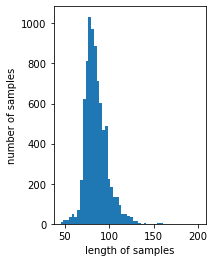

최대 길이 : 201
평균 길이 : 84.8803941132452


In [492]:
plt.subplot(122)
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

print('최대 길이 :',max(len(l) for l in X_train))
print('평균 길이 :',sum(map(len, X_train))/len(X_train))

3가지 옵션 입력
* `maxlen`: 최대 문장 길이 정의. 길면 잘라냄
* `truncating`: 문장 길이가 `maxlen`보다 길 때, 앞을 자를지 뒤를 자를지 정의
* `padding`: 문장 길이가 `maxlen`보다 짧을 때, 앞을 채울지 뒤를 채울지 정의

In [493]:
max_len = 150 # 최대 길이 (그래프를 보고 판단)
trunc_type = 'post' # 잘라낼 문장의 위치
padding_type = 'post'

문장 길이 비율 찾기

In [494]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))
    
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 150 이하인 샘플의 비율: 99.9126964330257


In [495]:
X_train = pad_sequences(X_train, maxlen = max_len, truncating = trunc_type, padding = padding_type)
X_test = pad_sequences(X_test, maxlen = max_len, truncating = trunc_type, padding = padding_type)

변화된 후 shape 확인

In [496]:
X_train.shape

(8018, 150)

## 모델 정의

~~임베딩 차원 정의~~

In [497]:
embedding_dim = 100

모델 구성

In [498]:
model = Sequential([
    Embedding(vocab_size, max_len),
    LSTM(100),
    Dense(1, activation='sigmoid')
])

## 컴파일

~~1. `optimizer`은 가장 최적화가 잘되는 알고리즘 'adam' 사용~~  
2. `loss`는 이진분류이므로, `binary_crossentropy` 사용

In [499]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

## ModelCheckpoint

val_acc 기준으로 epoch 마다 최적의 모델을 저장하기 위한 체크포인트 설정

In [500]:
mc = ModelCheckpoint(file_name+'.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

## EarlyStopping

val_loss 기준으로 4번까지 Overfitting(과적합)이 진행되면 자동으로 종료

In [501]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

## 모델 학습

In [502]:
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/15
26/26 [==============================] - ETA: 0s - loss: 0.2822 - acc: 0.9001
Epoch 00001: val_acc improved from -inf to 0.94264, saving model to LSTM_module_ver4.0.h5
26/26 [==============================] - 10s 372ms/step - loss: 0.2822 - acc: 0.9001 - val_loss: 0.2118 - val_acc: 0.9426
Epoch 2/15
26/26 [==============================] - ETA: 0s - loss: 0.1252 - acc: 0.9637
Epoch 00002: val_acc improved from 0.94264 to 0.98504, saving model to LSTM_module_ver4.0.h5
26/26 [==============================] - 9s 343ms/step - loss: 0.1252 - acc: 0.9637 - val_loss: 0.0629 - val_acc: 0.9850
Epoch 3/15
26/26 [==============================] - ETA: 0s - loss: 0.0538 - acc: 0.9880
Epoch 00003: val_acc did not improve from 0.98504
26/26 [==============================] - 9s 346ms/step - loss: 0.0538 - acc: 0.9880 - val_loss: 0.0744 - val_acc: 0.9813
Epoch 4/15
26/26 [==============================] - ETA: 0s - loss: 0.0589 - acc: 0.9871
Epoch 00004: val_acc did not improve from 0.985

학습 완료 후 `load_model` 를 해주지 않으면 ModelCheckpoint를 만든 의미가 없음

In [503]:
model = load_model(file_name+'.h5')

## 학습 오차 시각화

84/84 [==============================] - 2s 19ms/step - loss: 0.0480 - acc: 0.9895

 테스트 정확도: 0.9895


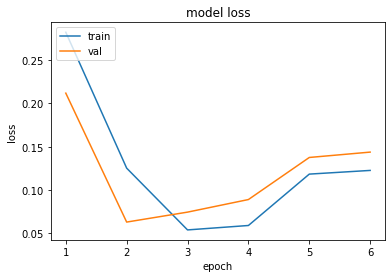

In [504]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

## 파일 저장

tokenizer 객체 저장

In [505]:
with open(file_name+"_tokenizer.pickle", "wb") as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

변수 저장

In [506]:
d = {'min_data':min_data, 'data_length':data_length, 'split_list':split_list,'max_len':max_len, 'trunc_type':trunc_type, 'padding_type':padding_type}
json_var = json.dumps(d)
with open(file_name+'_variable.json', 'w') as f:
    f.write(json_var)

불용어 단어 저장

In [507]:
json_stopwords = json.dumps(stopwords)
with open(file_name+'_stopwords.json', 'w') as f:
    f.write(json_stopwords)